## 패키지 가져오기

In [1]:
from pykrx import stock
from pykrx import bond
import pandas_datareader.data as web
import FinanceDataReader as fdr

from talib import RSI, BBANDS, MACD

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

from datetime import datetime
from dateutil.relativedelta import relativedelta
import time
from tqdm import tqdm

import multiprocessing as mp
from multiprocessing import Pool, Manager

import warnings
warnings.filterwarnings('ignore')

In [2]:
num_cores = mp.cpu_count()
print(f"사용가능한 코어 수: {num_cores}")

사용가능한 코어 수: 8


## 전략 수립 및 구현

2012년-2016년의 수익률의 상관관계를 기준으로(0.75) pair를 찾고  
pair에서 저평가된 주식을 매수, 고평가된 주식을 매도  
이 때, 저평가와 고평가의 여부는 페어로 묶인 두 주식의 ratio의 z-score를 사용   
(ratio의 z-score를 구할 때, ratio의 평균은 22영업일(1개월) 이동평균을, 분산은 22영업일(1개월) 이동분산을 사용함)  
평균에서 1 $\sigma$ 초과(또는 미만)가 되는 지의 여부를 기준으로 함.  
한편 2 $\sigma$ 초과(또는 미만)이 되는 경우, breakout을 사용해 비중이 0이 되도록 함.  
비중 설정 방식은 동일 가중 방식을 사용.  
이 때, 2012년~2016년 동안 계속해서 코스피에 상장되어있던 주식을 대상으로 함  
2017년 1월-2023년 1월의 기간동안, 리밸런싱은 1일마다 실시.  

In [3]:
start_date, end_date = "2012-01-01", "2016-12-31"
all_dates = stock.get_market_ohlcv(start_date, end_date, "005930").index
all_dates = all_dates.strftime('%Y-%m-%d')

In [4]:
# 쓰이는 모든 티커들을 모음
all_tickers = []
for date in tqdm(all_dates):
    kospi_tickers = stock.get_market_ticker_list(date, market='KOSPI')
    all_tickers += kospi_tickers
all_tickers = list(set(all_tickers))
print(f"해당 기간동안의 모든 ticker 개수는 {len(all_tickers)}")

100%|██████████| 1234/1234 [05:00<00:00,  4.11it/s]

해당 기간동안의 모든 ticker 개수는 1002


In [5]:
def return_price_df(tickers, start_date, end_date):
    df = pd.DataFrame()
    for ticker in tqdm(tickers):
        price_df = stock.get_market_ohlcv(start_date, end_date, ticker)['종가'].to_frame(ticker)
        df = pd.concat([df, price_df], axis=1)
    return df

price_df = return_price_df(all_tickers, start_date, end_date)
price_df.to_csv('pair_trading_price_df.csv')

100%|██████████| 1002/1002 [01:37<00:00, 10.26it/s]


In [6]:
price_df = pd.read_csv('pair_trading_price_df.csv', index_col=0)
price_df.index = pd.to_datetime(price_df.index, format='%Y-%m-%d')
price_df = price_df.dropna(axis=1)

In [7]:
def search_pairs(price_df, limit = 0.75):
    pairs = []
    all_tickers = []
    corr_mat = price_df.pct_change().fillna(0).corr()
    for i in range(corr_mat.shape[0]-1):
        for j in range(i+1, corr_mat.shape[1]):
            if corr_mat.iloc[i, j] > limit:
                pairs.append((price_df.columns[i], price_df.columns[j]))
                all_tickers += [price_df.columns[i], price_df.columns[j]]
    all_tickers = list(set(all_tickers))
    return pairs, all_tickers
pairs, all_tickers = search_pairs(price_df)

In [8]:
start_date, end_date = "2016-12-01", "2023-01-31"
pair_price_df = return_price_df(all_tickers, start_date, end_date)
pair_price_df = pair_price_df.fillna(0)

100%|██████████| 29/29 [00:04<00:00,  6.69it/s]


In [9]:
pair_daily_return = pd.DataFrame()

for i in range(len(pairs)):
    ticker1, ticker2 = pairs[i]
    temp_df = pair_price_df.loc[:, [ticker1, ticker2]]

    fwd_return = temp_df.pct_change().shift(-1)
    fwd_return = fwd_return.fillna(0)
    fwd_return.index = pd.to_datetime(fwd_return.index, format='%Y-%m-%d')

    ratio = temp_df[ticker1] / temp_df[ticker2]
    rolling_mean = ratio.rolling(window=22).mean()
    rolling_std = ratio.rolling(window=22).std()
    z_ratio = ((ratio-rolling_mean)/rolling_std).dropna()
    signal_df = pd.DataFrame()
    signal1 = ((1 < z_ratio) & (z_ratio< 2)).astype(int)
    signal2 = ((-2 < z_ratio) & (z_ratio< -1)).astype(int)
    signal_df[ticker1] = signal2 - signal1
    signal_df[ticker2] = signal1 - signal2

    daily_return = fwd_return.mul(signal_df).sum(axis=1)
    pair_daily_return[f'pair_{i}'] = daily_return

In [10]:
def calculate_daily_return(pair_daily_return):
    nonzero = (pair_daily_return != 0).sum(axis=1)
    daily_return = pair_daily_return.sum(axis=1).div(nonzero).fillna(0)
    return daily_return
daily_return = calculate_daily_return(pair_daily_return).to_frame("daily_return")
daily_return

,daily_return
날짜,
2016-12-01,0.000000
2016-12-02,0.000000
2016-12-05,0.000000
2016-12-06,0.000000
2016-12-07,0.000000
...,...
2023-01-25,0.006311
2023-01-26,0.001997
2023-01-27,0.009370


In [11]:
cumulative_return = (np.exp(np.log(daily_return['daily_return']+1).cumsum())-1).to_frame("cumulative_return")
cumulative_return

,cumulative_return
날짜,
2016-12-01,0.000000
2016-12-02,0.000000
2016-12-05,0.000000
2016-12-06,0.000000
2016-12-07,0.000000
...,...
2023-01-25,3.631369
2023-01-26,3.640617
2023-01-27,3.684099


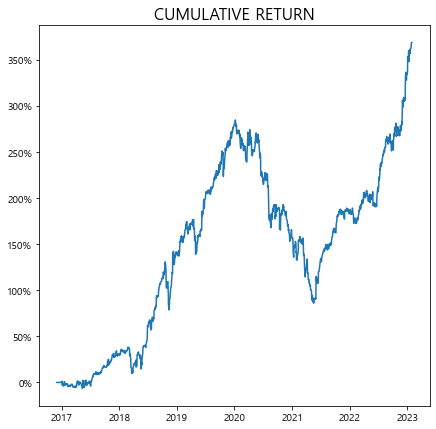

In [12]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.plot(cumulative_return)
ax.set_title("CUMULATIVE RETURN", fontsize=16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## 자세한 결과 분석

In [13]:
import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

Text(0.5, 1.0, 'Rolling Sharpe Ratio (3 Months)')

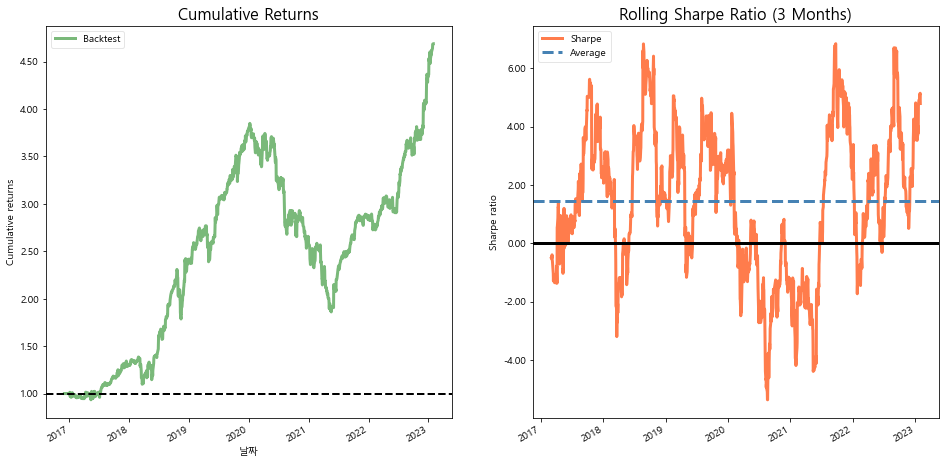

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

plot_rolling_returns(daily_return['daily_return'],
                     logy=False,
                     legend_loc='best',
                     volatility_match=False,
                    ax=axes[0])
plot_rolling_sharpe(daily_return['daily_return'], ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns', fontsize=16)
axes[1].set_title('Rolling Sharpe Ratio (3 Months)', fontsize=16)

Start date,2016-12-01
End date,2023-01-31
Total months,72
,Backtest
Annual return,29.287%
Cumulative returns,368.919%
Annual volatility,23.455%
Sharpe ratio,1.21
Calmar ratio,0.57
Stability,0.66
Max drawdown,-51.659%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,51.66,2020-01-07,2021-05-18,2022-11-30,757
1,22.64,2018-10-19,2018-11-13,2018-12-06,35
2,20.74,2018-02-26,2018-03-21,2018-06-04,71
3,13.67,2019-04-11,2019-04-30,2019-06-10,43
4,7.89,2019-10-14,2019-10-23,2019-11-05,17


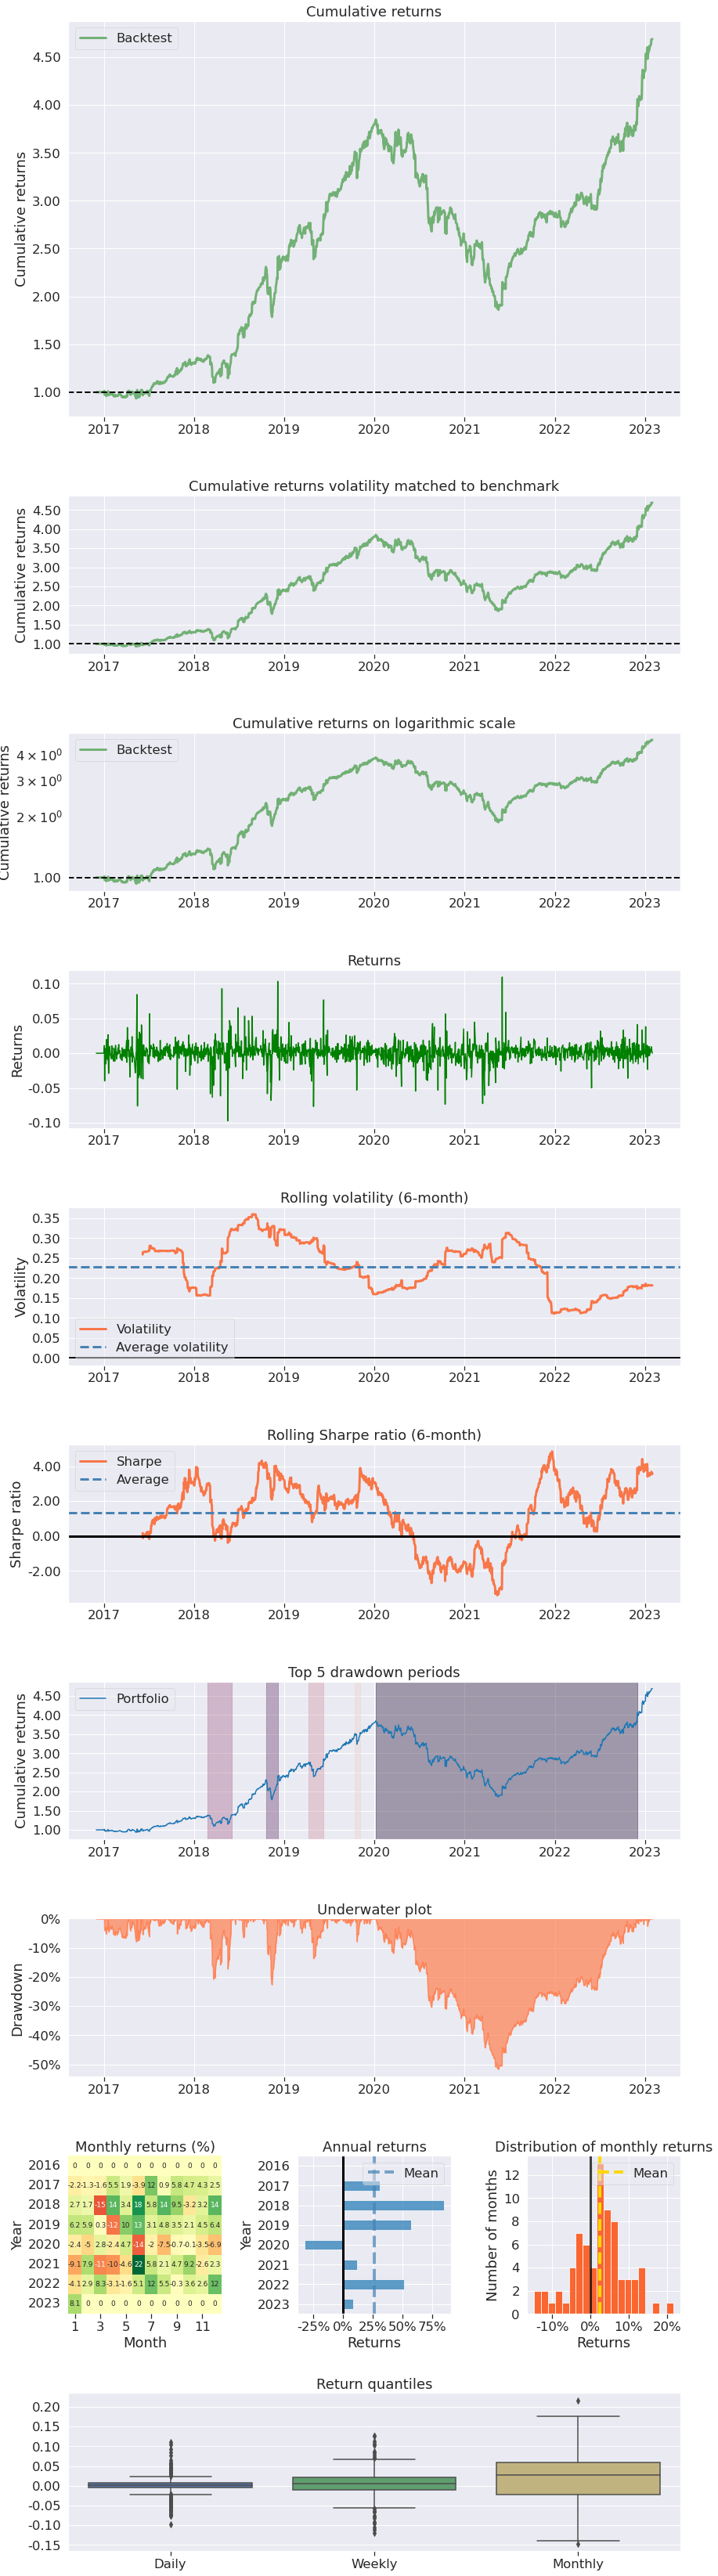

In [15]:
pf.create_returns_tear_sheet(daily_return['daily_return'])